In [1]:
# clustering R & Python
# simulation

import math
import networkx as nx
import graspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspy.plot import heatmap, pairplot
from graspy.cluster.pyclust import PyclustCluster
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.mixture.gaussian_mixture import _estimate_gaussian_parameters
from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
from scipy.sparse.linalg import eigsh 
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns; 

%matplotlib inline

In [2]:
## #####  rpy2 stuff  ######
# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
# R package names
packnames = ('mclust')
utils = rpackages.importr('utils')
base = rpackages.importr('base')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))

mclust = rpackages.importr('mclust',lib_loc ="D:/Program Files/R/R-3.6.1/library")
## new def for R's mclust
def cluster_R(E,label):
    nr,nc = E.shape
    Er = robjects.r.matrix(E, nrow=nr, ncol=nc)
    robjects.r.assign("E", Er)
    mc = mclust.Mclust(Er, G=2, verbose=0)
    Y = mc.rx2("classification")
    classification = np.array(Y, dtype=np.uint8) - 1
    npara = mclust.nMclustParams(mc.rx2("modelName"), 2, 2)
    bic = np.mat(mc.rx2("bic"))
    bic = - bic 
    aic = -2 * np.mat(mc.rx2("loglik")) + 2 * np.mat(npara)
    ari = adjusted_rand_score(label, classification)
    #results = np.array([bic,aic,ari])
    results = pd.DataFrame({"classification":[classification],"bic":[bic],"aic":[aic],"ari":[ari] })
    return results

In [3]:
def cluster_python(X, label):
    gmm_ase = GaussianMixture(n_components=2).fit(ase_Xhat)
    ase_gmm = gmm_ase.predict(ase_Xhat)
    ari = adjusted_rand_score(label, ase_gmm)
    #results = np.array([gmm_ase.bic,gmm_ase.aic,ari])
    results = pd.DataFrame({"classification":[ase_gmm],"bic":[gmm_ase.bic(X)],"aic":[gmm_ase.aic(X)],"ari":[ari] })
    return results

In [4]:
# define python gmm function that initialized by R result
def cluster_Rpython(X, label, label_init):
    labels = label_init.astype(int)
    n = int(len(labels))
    k = int(max(labels) + 1)
    onehot = np.zeros([n, k])
    onehot[np.arange(n), labels] = 1

    cov_type = 'full'
    n = X.shape[0]
    weights, means, covariances = _estimate_gaussian_parameters(X, onehot, 1e-06, cov_type)
    weights /= n
    precisions_cholesky_ = _compute_precision_cholesky(covariances, cov_type)
    precisions = [np.dot(c, c.T) for c in precisions_cholesky_]
    gmm_ase = GaussianMixture(n_components=2,weights_init=weights,means_init=means,precisions_init=precisions).fit(ase_Xhat)
    ase_gmm = gmm_ase.predict(ase_Xhat)
    ari = adjusted_rand_score(label, ase_gmm)
    results = pd.DataFrame({"classification":[ase_gmm],"bic":[gmm_ase.bic(X)],"aic":[gmm_ase.aic(X)],"ari":[ari] })
    return results
    

In [5]:
# generate single SBM graph
np.random.seed(3000)

n_verts = 800
labels_sbm = int(0.28 * n_verts) * ["LG"] + int(0.22 * n_verts) * ["LW"] + int(0.28 * n_verts) * ["RG"] + int(0.22 * n_verts) * ["RW"]
labels_lr = int(0.28 * n_verts) * [0] + int(0.22*n_verts) * [0] + int(0.28*n_verts) * [1] + int(0.22*n_verts) * [1] #true label
labels_gw = int(0.28 * n_verts) * [0] + int(0.22*n_verts) * [1] + int(0.28*n_verts) * [0] + int(0.22*n_verts) * [1] #true label
n_verts = int(0.28 * n_verts) + int(0.22*n_verts) + int(0.28*n_verts) + int(0.22*n_verts)

P = np.array(
	[[0.018932108, 0.042869173, 0.002084243, 0.008436194],
	[0.042869173, 0.112538688, 0.009629583, 0.040333219],
	[0.002084243, 0.009629583, 0.019360040, 0.044269707],
	[0.008436194, 0.040333219, 0.044269707, 0.115217630	]])

times=100
# undirected_sbm = sbm([int(0.28 *n_verts),int(0.22 *n_verts),int(0.28 *n_verts),int(0.22 *n_verts)], P)

In [6]:
R_results = pd.DataFrame(columns=["classification","bic","aic","ari"] )
python_results = pd.DataFrame(columns=["classification","bic","aic","ari"] )
Rpython_results = pd.DataFrame(columns=["classification","bic","aic","ari"] )
for i in range(times):
    undirected_sbm = sbm([int(0.28 *n_verts),int(0.22 *n_verts),int(0.28 *n_verts),int(0.22 *n_verts)], P)
    ase = AdjacencySpectralEmbed()
    ase_Xhat = ase.fit_transform(undirected_sbm)
    R_entry= cluster_R(ase_Xhat,labels_gw)
    R_results = R_results.append(R_entry,ignore_index=True,sort=False)
    python_results = python_results.append(cluster_python(ase_Xhat,labels_gw),ignore_index=True,sort=False)
    Rpython_results = Rpython_results.append(cluster_Rpython(ase_Xhat,labels_gw,R_entry.loc[0,"classification"]),ignore_index=True,sort=False)
    

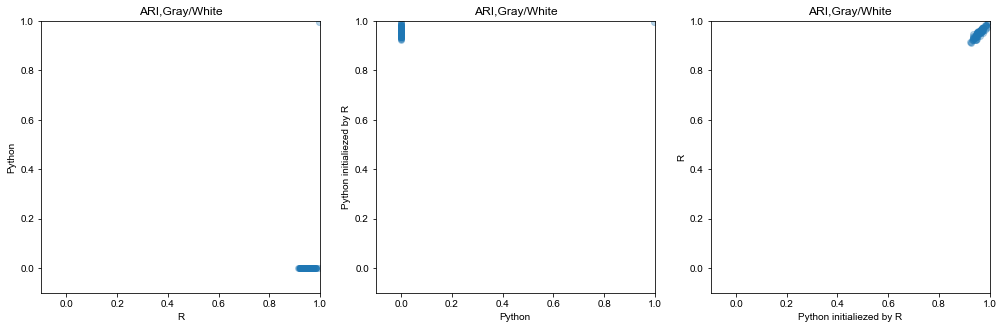

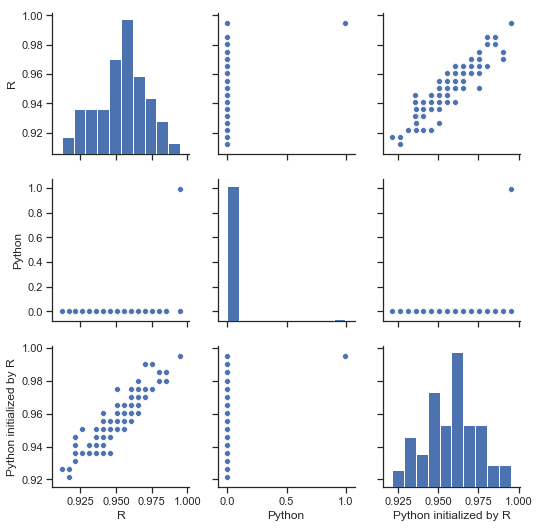

In [7]:
# ARI
ari=np.zeros([times,3])
for i in range(times):
    ari[i,0] = R_results.loc[i,"ari"]
    ari[i,1] = python_results.loc[i,"ari"]
    ari[i,2] = Rpython_results.loc[i,"ari"]

plt.figure(figsize=(17,5))
plt.subplot(131)
plt.scatter(ari[:,0], ari[:,1], alpha=0.3)
plt.title("ARI,Gray/White")
plt.xlabel("R");plt.ylabel("Python")
plt.xlim(-0.1,1);plt.ylim(-0.1,1)

plt.subplot(132)
plt.scatter(ari[:,1], ari[:,2], alpha=0.3)
plt.title("ARI,Gray/White")
plt.xlabel("Python");plt.ylabel("Python initialiezed by R")
plt.xlim(-0.1,1);plt.ylim(-0.1,1)

plt.subplot(133)
plt.scatter(ari[:,2], ari[:,0], alpha=0.3)
plt.title("ARI,Gray/White")
plt.xlabel("Python initialiezed by R");plt.ylabel("R")
plt.xlim(-0.1,1);plt.ylim(-0.1,1)
# pairplot(ari,col_names=["R","Python","Python initialized by R"],title="ARI")
ari = pd.DataFrame(ari, columns=["R","Python","Python initialized by R"])

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(ari)
#plt.title("ARI (Gray/White)")
#print("ARI (Gray/White)")

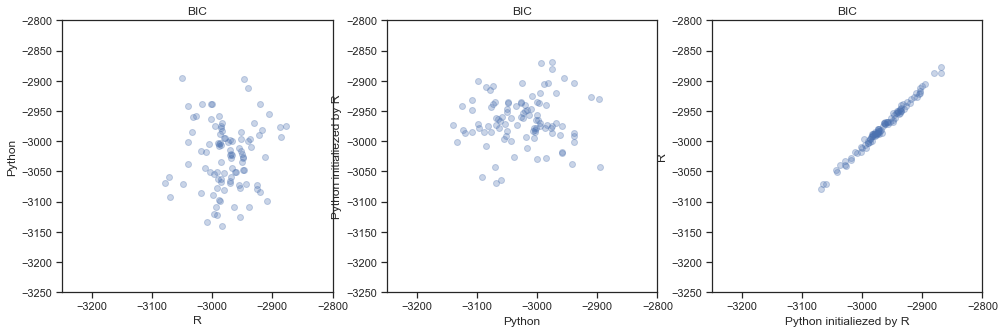

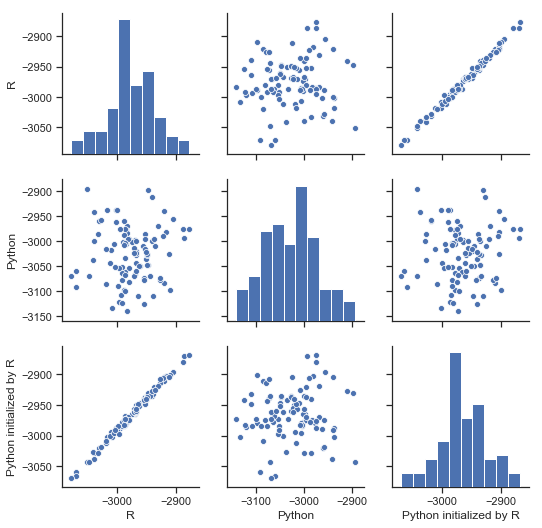

In [8]:
bic=np.zeros([times,3])
for i in range(times):
    bic[i,0] = R_results.loc[i,"bic"]
    bic[i,1] = python_results.loc[i,"bic"]
    bic[i,2] = Rpython_results.loc[i,"bic"]
    
plt.figure(figsize=(16.5,5))
plt.subplot(131)
plt.scatter(bic[:,0], bic[:,1], alpha=0.3)
plt.title("BIC")
plt.xlabel("R");plt.ylabel("Python")
plt.xlim(-3250,-2800);plt.ylim(-3250,-2800)

plt.subplot(132)
plt.scatter(bic[:,1], bic[:,2], alpha=0.3)
plt.title("BIC")
plt.xlabel("Python");plt.ylabel("Python initialiezed by R")
plt.xlim(-3250,-2800);plt.ylim(-3250,-2800)

plt.subplot(133)
plt.scatter(bic[:,2], bic[:,0], alpha=0.3)
plt.title("BIC")
plt.xlabel("Python initialiezed by R");plt.ylabel("R")
plt.xlim(-3250,-2800);plt.ylim(-3250,-2800)
# pairplot(ari,col_names=["R","Python","Python initialized by R"],title="ARI")
bic = pd.DataFrame(bic, columns=["R","Python","Python initialized by R"])
#axes = plt.subplots()
# sns.set(style="ticks", color_codes=True)
sns.pairplot(bic)

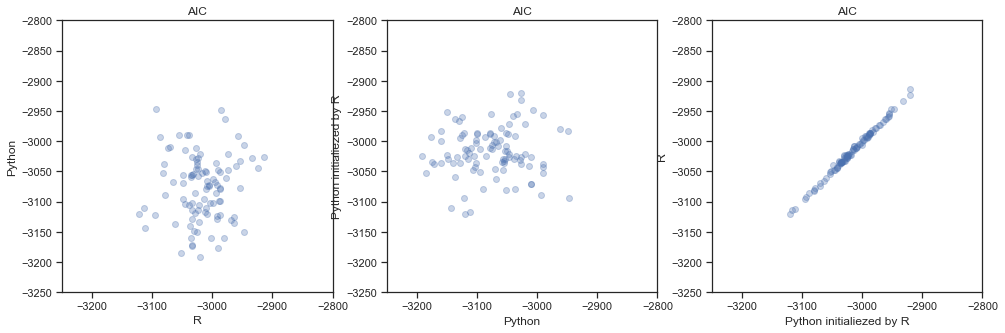

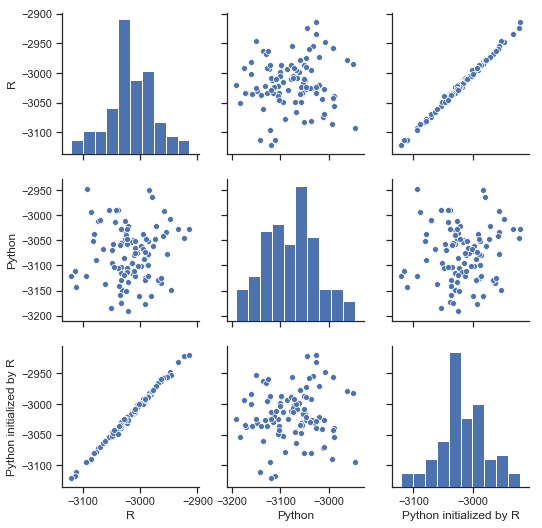

In [9]:
aic=np.zeros([times,3])
for i in range(times):
    aic[i,0] = R_results.loc[i,"aic"]
    aic[i,1] = python_results.loc[i,"aic"]
    aic[i,2] = Rpython_results.loc[i,"aic"]
    
plt.figure(figsize=(16.5,5))
plt.subplot(131)
plt.scatter(aic[:,0], aic[:,1], alpha=0.3)
plt.title("AIC")
plt.xlabel("R");plt.ylabel("Python")
plt.xlim(-3250,-2800);plt.ylim(-3250,-2800)

plt.subplot(132)
plt.scatter(aic[:,1], aic[:,2], alpha=0.3)
plt.title("AIC")
plt.xlabel("Python");plt.ylabel("Python initialiezed by R")
plt.xlim(-3250,-2800);plt.ylim(-3250,-2800)

plt.subplot(133)
plt.scatter(aic[:,2], aic[:,0], alpha=0.3)
plt.title("AIC")
plt.xlabel("Python initialiezed by R");plt.ylabel("R")
plt.xlim(-3250,-2800);plt.ylim(-3250,-2800)
# pairplot(ari,col_names=["R","Python","Python initialized by R"],title="ARI")
aic = pd.DataFrame(aic, columns=["R","Python","Python initialized by R"])

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(aic)